In [1]:
import numpy as np
import h5py
import numpy as np
import h5py
from copy import deepcopy
import os, zipfile, shutil,gzip
import pandas as pd
import glob
from scipy.stats import linregress
import os
import requests
from datetime import datetime
from datetime import timedelta
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import scipy
from numpy import polyfit, poly1d
from scipy import interpolate
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import time
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import math
import plotly
import ccxt
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import json
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean
from scipy import interpolate

secret='TD.a-ZsKkoLFWpWQpFK.dejlvOF7NK0XBVM.LlD63gOWm7VaNIu.WzC3t3XtgjavrVM.PxZSkA5B3pBRC2T.baP4'
import nest_asyncio
nest_asyncio.apply()
from tardis_dev import datasets

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# 检查coin成交量的变化

In [4]:
def make_s(df):
    df['time']=pd.to_datetime(df['time']).dt.floor('S')
    df['value']=df['amount']*df['price']
    df1=df['price'].groupby(df['time']).min().to_frame('min')
    df2=df['price'].groupby(df['time']).max().to_frame('max')
    df3=df['value'].groupby(df['time']).sum().to_frame('sum')
    df1=df1.merge(df2,on='time').merge(df3,on='time')
    return df1

def get_s_data(site,name,begin,end):
    df = []
    for name1 in os.listdir(f'Y:/Trade Pro/data_wei/{site}/trade/{name}/datasets'):
        if site=='kraken':
            time = name1[14:24]
        elif site == 'binance':
            time = name1[24:34]
        else:
            time=name1[16:26]
        size = os.path.getsize(f'Y:/Trade Pro/data_wei/{site}/trade/{name}/datasets/{name1}')
        if time >= begin and time <= end and size>1000 and name1[-2:]=='gz':
            df1 = pd.read_csv(f'Y:/Trade Pro/data_wei/{site}/trade/{name}/datasets/{name1}')
            df.append(df1)
    df = pd.concat(df, axis=0, ignore_index=True)
    df['time'] = 'abc'
    f = lambda x: datetime.fromtimestamp(x / 1000000)
    df['time'] = df['timestamp'].map(f)
    for side in ['sell']:
        df_side = df[df['side'] == side]
        return make_s(df_side)

In [21]:
df = get_s_data('kraken', 'MATIC-USD', '2023-08-14', '2024-01-25')

In [22]:
df = df.reset_index()

In [23]:
df['time'] = df['time'].astype('datetime64[D]')

In [24]:
df = df.groupby('time', as_index = False).sum()

Text(0.5, 1.0, 'MATIC-USD')

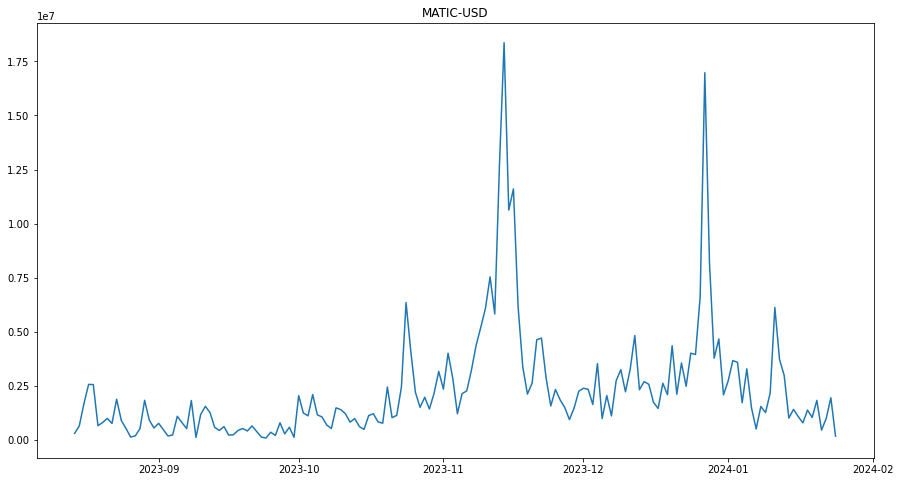

In [25]:
plt.figure(figsize = (15, 8))
plt.plot(df.time, df['sum'])
plt.title('MATIC-USD')

In [6]:
dt = []
for coin in os.listdir(f'Y:/Trade Pro/data_wei/kraken/trade'):
    coin = coin.replace('XBT', 'BTC').replace('XDG', 'DOGE')
    for side in ['buy', 'sell']:
        amount = [coin, side, 0]
        df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/kraken/proba_sheet/{coin}_{side}.csv')
        a1 = df[df['prob'] < 0.1]['amount'].values[0]
        a2 = df[df['prob'] < 0.09]['amount'].values[0]
        amount[2] = (np.log10(0.1) - np.log10(0.05)) / (np.log10(a1) - np.log10(a2))
        dt.append(amount)
dt = pd.DataFrame(dt, columns = ['coin', 'side', 'k'])

In [13]:
dt.sort_values('k', ascending = False).reset_index().to_csv(f'C:/Users/杜威/Desktop/sort.csv')

In [16]:
dt.sort_values(by = ['-1', '0']).to_csv(r'C:/Users/杜威/Desktop/sort.csv')

# 数字币永续资金费率对比

In [109]:
coin_ls = ['BTC', 'ETH', 'SOL', 'LINK', 'ADA', 'DOGE', 'XRP', 'DOT', 'MATIC', 'LTC']
path = f'C:/Users/杜威/Desktop/tardis/Tom_data/fundingrate'

In [61]:
def add_df(df, path):
    df_b = pd.read_csv(path)
    df_b['time'] = df_b['time'].astype('datetime64[D]')
    df = pd.concat([df, df_b]).reset_index()[['time', 'fundingRate']]
    df = df[~df['time'].duplicated()].sort_values('time')
    df.to_csv(path)

In [62]:
#kraken
def down_load_kk(coin):
    coin = coin.replace('BTC', 'XBT')
    url = f'https://futures.kraken.com/derivatives/api/v4/historicalfundingrates?symbol=PF_{coin}USD'
    df = requests.get(url).json()
    df = pd.DataFrame(df['rates'])
    df['time'] = df['timestamp'].astype('datetime64[D]')
    df['fundingRate'] = df['relativeFundingRate'].astype(float)
    df = df[['time', 'fundingRate']].groupby('time', as_index = False).sum()
    add_df(df, f'{path}/kraken/{coin}.csv')
    
for coin1 in coin_ls:
    down_load_kk(coin1)

In [63]:
#binance
def get_lim_df_bi(coin, tlim):
    tlim = str(int(tlim) - 28771200000)
    url = f'https://fapi.binance.com/fapi/v1/fundingRate?symbol={coin}USDT&limit=1000&startTime={tlim}'
    df = requests.get(url).json()
    df = pd.DataFrame(df)
    tlim = df['fundingTime'].min()
    f = lambda x: datetime.fromtimestamp(int(x) / 1000)
    df['time'] = (df['fundingTime'].map(f) - timedelta(hours = 8)).astype('datetime64[D]')
    df['fundingRate'] = df['fundingRate'].astype(float)
    return df, tlim
def down_load_bi(coin):
    tlim = str(int(time.time()) * 1000)
    i = 0
    d_a = []
    while i < 10:
        try:
            df, tlim = get_lim_df_bi(coin, tlim)
        except:
            break
        d_a.append(df)
        i += 1
    d_a = pd.concat(d_a)
    d_a = d_a.drop_duplicates()
    d_a = d_a[['time', 'fundingRate']].groupby('time', as_index = False).sum()
    add_df(d_a, f'{path}/binance/{coin}.csv')
    
for coin in coin_ls[-2:] + ['USDC']:
    down_load_bi(coin)

In [65]:
#Okex
def get_lim_df_ok(coin, tlim):
    url = f'https://www.okx.com/api/v5/public/funding-rate-history?instId={coin}-USDT-SWAP&after={tlim}'
    df = requests.get(url).json()
    df = pd.DataFrame(df['data'])
    tlim = df['fundingTime'].min()
    f = lambda x: datetime.fromtimestamp(int(x) / 1000)
    df['time'] = (df['fundingTime'].map(f) - timedelta(hours = 8)).astype('datetime64[D]')
    df['fundingRate'] = df['realizedRate'].astype(float)
    return df, tlim

def down_load_ok(coin):
    tlim = str(int(time.time()) * 1000)
    i = 0
    d_a = []
    while i < 10:
        try:
            df, tlim = get_lim_df_ok(coin, tlim)
        except:
            break
        d_a.append(df)
        i += 1
    d_a = pd.concat(d_a)
    d_a = d_a.drop_duplicates()
    d_a = d_a[['time', 'fundingRate']].groupby('time', as_index = False).sum()
    add_df(d_a, f'{path}/okex/{coin}.csv')

for coin in coin_ls + ['USDC']:
    down_load_ok(coin)

In [111]:
#CME
def down_load_CME(coin):
    df = pd.read_csv(f'{path}/CME/raw data/CME_DL_{coin}1!, 1D.csv')
    f = lambda x: datetime.fromtimestamp(int(x))
    df['time'] = (df['time'].map(f) - timedelta(hours = 8)).astype('datetime64[D]')
    df['fundingRate'] = (df[f'{coin}2! · CME: Open'] / df[f'{coin}1! · CME: Open'] - 1) / 30
    df[['time', 'fundingRate']].to_csv(f'{path}/CME/rate/{coin}.csv')

for coin in ['BTC', 'ETH']:
    down_load_CME(coin)

In [113]:
#不同交易所对比
df = []
for coin in coin_ls + ['USDC']:
    df0 = [coin]
    file = coin + '.csv'
    for lim in [-31, -91]:
        for ex in ['binance', 'okex', 'kraken', 'CME/rate']:
            if ex == 'kraken' and coin == 'BTC':
                file = file.replace('BTC', 'XBT')
            else:
                file = file.replace('XBT', 'BTC')
            if file not in os.listdir(f'{path}/{ex}'):
                df0.append(np.nan)
                continue
            else:
                dt = pd.read_csv(f'{path}/{ex}/{file}')
                dt.rename(columns = {'relativeFundingRate': 'fundingRate'}, inplace = True)
                df0.append(dt.iloc[lim:-1, :]['fundingRate'].sum())
    df.append(df0)

In [117]:
df = pd.DataFrame(df, columns = ['coin', 'binance_m', 'okex_m', 'kraken_m','CME_m','binance_3m', 'okex_3m', 'kraken_3m','CME_3m'])

In [118]:
df.to_csv(f'{path}/result.csv')

In [57]:
#binance极端值
df = []
for coin in coin_ls:
    df0 = [coin]
    cols = ['coin']
    file = coin + '.csv'
    tls = ['2021-01-01', '2022-01-01', '2023-01-01']
    for lim in range(2):
        year = tls[lim][:4]
        dt = pd.read_csv(f'{path}/binance/{file}')
        dt = dt[dt['time'] >= tls[lim]][dt['time'] < tls[lim + 1]]
        days = dt.sort_values('fundingRate').reset_index()['fundingRate'][2]
        for gap in ['D', 'M']:
            dt['time'] = dt['time'].astype(f'datetime64[{gap}]')
            dt = dt[['time', 'fundingRate']].groupby('time', as_index = False).sum()
            for sort in ['max', 'min']:
                if sort == 'max':
                    sq = dt.sort_values('fundingRate', ascending = False).reset_index()['fundingRate']
                else:
                    sq = dt.sort_values('fundingRate', ascending = True).reset_index()['fundingRate']
                for i in range(3):
                    cols.append(f'{year}_{gap}_{sort}_{i+1}')
                    df0.append(sq[i])
    df.append(df0)
df = pd.DataFrame(df, columns = cols)

In [59]:
df.to_csv(f'{path}/sort.csv')

# 下载python库和tardis文件

In [1]:
!pip install --user -i https://pypi.tuna.tsinghua.edu.cn/simple pdfminer
#!pip install D:\临时下载\tick-0.7.0.1-cp38-abi3-win_amd64.whl
#!pip install okx

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
site = 'kraken'
for name in tqdm(os.listdir(r'Y:\Trade Pro\data_wei\kraken\trade')):
    if name == '.DS_Store':
        continue
    if name[:4] in ['ATOM', 'AVAX']:
        continue
    down_data(site, name, 'trades', '2023-11-15', '2024-01-21')
    crp_ls = ['XBT','ETH','SOL','DOT','XRP','LTC','BTC','XDG','ADA']
    if name[:3] in crp_ls or name[:5] == 'MATIC' or name[:4] in ['ATOM', 'AVAX', 'LINK']:
        continue
    down_data(site, name, 'book_snapshot_5', '2023-11-15', '2024-01-21')

  4%|███▎                                                                               | 3/74 [02:07<50:20, 42.54s/it]download file attempt error, next attempt delay: 2s, url: https://datasets.tardis.dev/v1/kraken/book_snapshot_5/2023/11/21/PAXG-EUR.csv.gz download path: ./datasets/kraken_book_snapshot_5_2023-11-21_PAXG-EUR.csv.gz
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\tardis_dev\datasets\download.py", line 129, in _reliably_download_file
    await _download(session, url, download_path, http_proxy)
  File "D:\anaconda3\lib\site-packages\tardis_dev\datasets\download.py", line 177, in _download
    async for data in response.content.iter_any():
  File "D:\anaconda3\lib\site-packages\aiohttp\streams.py", line 35, in __anext__
    rv = await self.read_func()
  File "D:\anaconda3\lib\site-packages\aiohttp\streams.py", line 397, in readany
    await self._wait("readany")
  File "D:\anaconda3\lib\site-packages\aiohttp\streams.py", line 304, in _wait
    awa

In [2]:
def down_data(exchange,name,data_type,begin,end):
    dip=exchange
    if data_type=='trades':
        path = f"Y:/Trade Pro/data_wei/{exchange}/trade/{name}"
    elif data_type=='book_snapshot_5':
        path = f"Y:/Trade Pro/data_wei/{exchange}/5level/{name}"
    elif data_type=='incremental_book_L2':
        path = f"Y:/Trade Pro/data_wei/{exchange}/diff/{name}"
    elif data_type=='book_ticker':
        path = f"Y:/Trade Pro/data_wei/{exchange}/ticker/{name}"
    elif data_type == 'book_snapshot_25':
        path = f"Y:/Trade Pro/data_wei/{exchange}/25level/{name}"
    if not os.path.exists(path):
        os.mkdir(path)
    os.chdir(path)
    datasets.download(
            exchange=dip,
            data_types=[
                data_type
            ],
            from_date=begin,
            to_date=end,
            symbols=[name],
            api_key=secret,
        )

def get_data(begintime,endtime):
    data_types=['book_snapshot_5','book_ticker']
    ib_coin_map={
        'binance':['BTCBUSD','BTCUSDT','SOLBUSD','SOLUSDT','ETHBUSD','ETHUSDT',
                   'MATICBUSD','MATICUSDT','DOTBUSD','DOTUSDT','BUSDUSDT','USDCUSDT',
                   'XRPBUSD','XRPUSDT','LTCBUSD','LTCUSDT','DOGEUSDT','ADAUSDT','LINKUSDT','XMRUSDT'],
        'okex':['USDC-USDT','XRP-USDT','LTC-USDT','ETH-USDT','BTC-USDT','DOGE-USDT','ADA-USDT',
                'LINK-USDT','XMR-USDT'],
        'coinbase':['ETH-USD','BTC-USD','SOL-USD','MATIC-USD','DOT-USD','USDT-USD','LTC-USD','XRP-USD',
                    'DOGE-USD','ADA-USD','LINK-USD'],
        'kraken':['USDC-USDT'],
        'kucoin':['XMR-USDT','XRP-USDT']
    }
    ib_coin_map = {
        'coinbase':['ETH-USD','BTC-USD','SOL-USD','MATIC-USD','DOT-USD','USDT-USD'],
        'binance':['BTCUSDT', 'SOLUSDT', 'ETHUSDT', 'MATICUSDT', 'DOTUSDT'],
        'okex':['BTC-USDT', 'SOL-USDT', 'ETH-USDT', 'MATIC-USDT', 'DOT-USDT'],
    }
    ticker_ls = ['coinbase']
    ob_ls = ['binance', 'okex']
    for dip in ib_coin_map:
        nalis=ib_coin_map[dip]
        if dip in ob_ls:
            data_type=data_types[0]
        elif dip in ticker_ls:
            data_type=data_types[1]
        for name in tqdm(nalis):
            down_data(dip,name,data_type,begintime,endtime)

In [3]:
begin='2023-04-01'
end='2023-08-01'
get_data(begin,end)

 20%|████████████████▌                                                                  | 1/5 [01:53<07:33, 113.26s/it]download file attempt error, next attempt delay: 2s, url: https://datasets.tardis.dev/v1/okex/book_snapshot_5/2023/04/24/SOL-USDT.csv.gz download path: ./datasets/okex_book_snapshot_5_2023-04-24_SOL-USDT.csv.gz
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\tardis_dev\datasets\download.py", line 129, in _reliably_download_file
    await _download(session, url, download_path, http_proxy)
  File "D:\anaconda3\lib\site-packages\tardis_dev\datasets\download.py", line 177, in _download
    async for data in response.content.iter_any():
  File "D:\anaconda3\lib\site-packages\aiohttp\streams.py", line 35, in __anext__
    rv = await self.read_func()
  File "D:\anaconda3\lib\site-packages\aiohttp\streams.py", line 397, in readany
    await self._wait("readany")
  File "D:\anaconda3\lib\site-packages\aiohttp\streams.py", line 304, in _wait
    await w

KeyboardInterrupt: 